# Clustering

In [ ]:
import pandas as pd
import numpy as np
import requests
from sklearn.preprocessing import StandardScaler

In [ ]:
# https://public.opendatasoft.com/api/records/1.0/search/?dataset=airbnb-listings&q=where+country_code+%3D+'US'+and+city+%3D+%22New+York%22&rows=10
r = requests.get("https://public.opendatasoft.com/api/records/1.0/search/?dataset=airbnb-listings&q=where+country_code+%3D+'US'&rows=10000")#+and+city+%3D+%22New+York%22
records = r.json()['records']

In [ ]:
df_records = []
for r in records:
  df_records.append(r['fields'])

In [ ]:
df = pd.DataFrame(df_records)
df = df.sort_index(axis=1)
data=df[['reviews_per_month','price','availability_365']] # 변수 추출 
data=data.dropna(axis=0) # 결측치 제거

data

,reviews_per_month,price,availability_365
2,0.81,77.0,365
3,2.77,130.0,343
4,5.98,40.0,316
5,1.71,295.0,353
6,0.14,80.0,0
...,...,...,...
9994,0.06,63.0,0
9995,0.25,160.0,28
9996,0.23,550.0,221
9998,2.43,80.0,64


In [ ]:
data.describe()

,reviews_per_month,price,availability_365
count,8304.000000,8304.000000,8304.000000
mean,1.907710,141.273964,178.859947
std,1.874212,115.900994,135.102358
min,0.010000,10.000000,0.000000
25%,0.480000,72.000000,45.750000
50%,1.270000,105.000000,165.500000
75%,2.770000,170.000000,320.000000
max,12.630000,999.000000,365.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8304 entries, 2 to 9999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   reviews_per_month  8304 non-null   float64
 1   price              8304 non-null   float64
 2   availability_365   8304 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 259.5 KB


In [ ]:
# 이상치 제거 함수 (1Q - 1.5*IQR, 3Q + 1.5*IQR 을 넘어가는 값을 가진 행을 제거)

def get_outlier(df=None, column=None, weight=1.5):
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

In [ ]:
outlier_idx = get_outlier(df=data, column='reviews_per_month', weight=1.5)
data.drop(outlier_idx, axis=0, inplace=True)

In [ ]:
outlier_idx = get_outlier(df=data, column='price', weight=1.5)
data.drop(outlier_idx, axis=0, inplace=True)

In [ ]:
outlier_idx = get_outlier(df=data, column='availability_365', weight=1.5)
data.drop(outlier_idx, axis=0, inplace=True)

In [ ]:
# scaling (z-standardization)
data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index = data.index)
data.head()

,reviews_per_month,price,availability_365
2,-0.601631,-0.640230,1.393394
3,0.687599,0.165411,1.231363
4,2.799042,-1.202658,1.032507
5,-0.009637,2.673538,1.305014
6,-1.042337,-0.594628,-1.294843


In [ ]:
data.describe() #기초통계량

,reviews_per_month,price,availability_365
count,7.492000e+03,7.492000e+03,7.492000e+03
mean,1.908659e-16,3.277914e-17,1.415119e-16
std,1.000067e+00,1.000067e+00,1.000067e+00
min,-1.127847e+00,-1.658682e+00,-1.294843e+00
25%,-8.186951e-01,-7.466354e-01,-9.947178e-01
50%,-3.286561e-01,-2.906123e-01,-1.164377e-01
75%,5.840004e-01,4.694262e-01,1.061967e+00
max,2.943752e+00,3.144762e+00,1.393394e+00


In [ ]:
data_elbow=data

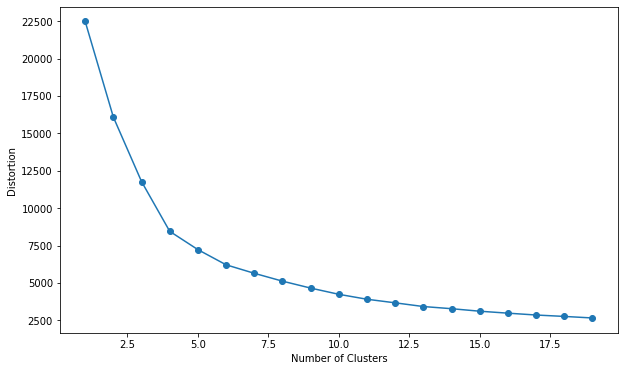

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# graph를 통해 k값 선정
# distortion = 군집내 오차제곱합(SSE; Sum of Suqared Errors)
distortions = []
for i in range(1,20):
    km = KMeans(
    n_clusters= i, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
    )
    km.fit(data_elbow)
    distortions.append(km.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1,20), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=4, random_state=20210330, algorithm='auto')

model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=20210330, tol=0.0001, verbose=0)

In [ ]:
# 각 군집(cluster) 표시
pred = model.predict(data)
pred

array([1, 1, 0, ..., 3, 3, 0], dtype=int32)

In [ ]:
# 원형 데이터에 군집 예측치 추가
data['k_means_cluster'] = pred
data

,reviews_per_month,price,availability_365,k_means_cluster
2,-0.601631,-0.640230,1.393394,1
3,0.687599,0.165411,1.231363,1
4,2.799042,-1.202658,1.032507,0
5,-0.009637,2.673538,1.305014,2
6,-1.042337,-0.594628,-1.294843,3
...,...,...,...,...
9993,2.581978,0.241415,0.649526,0
9994,-1.094959,-0.853041,-1.294843,3
9995,-0.969982,0.621434,-1.088622,3
9998,0.463957,-0.594628,-0.823481,3


In [ ]:
# 군집별 centroid
centers = model.cluster_centers_
centers

array([[ 1.61865263, -0.25388216,  0.08048571],
       [-0.33890993, -0.3959539 ,  1.07097826],
       [-0.31460558,  1.71705777,  0.04142238],
       [-0.49601039, -0.37326753, -0.9023486 ]])

In [ ]:
pd.DataFrame(centers)

,0,1,2
0,1.618653,-0.253882,0.080486
1,-0.338910,-0.395954,1.070978
2,-0.314606,1.717058,0.041422
3,-0.496010,-0.373268,-0.902349


In [ ]:
# 군집별 통계(평균)
cluster_k = data.groupby('k_means_cluster')
cluster_k.mean()

,reviews_per_month,price,availability_365
k_means_cluster,,,
0,1.617099,-0.254717,0.082182
1,-0.340624,-0.395556,1.071187
2,-0.314606,1.717058,0.041422
3,-0.496010,-0.373268,-0.902349


In [ ]:
# 군집별 통계(표준편차)
cluster_k.std()

,reviews_per_month,price,availability_365
k_means_cluster,,,
0,0.624927,0.697953,0.854411
1,0.549438,0.586461,0.331751
2,0.712273,0.649605,0.954553
3,0.515420,0.603478,0.419602


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

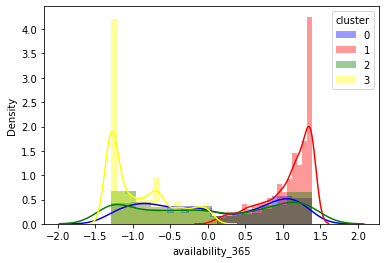

In [ ]:
# 시각화: reviews_per_month
import seaborn as sns

sns.distplot(data[data.k_means_cluster == 0]["availability_365"], 
             color="blue", label=0)

sns.distplot(data[data.k_means_cluster == 1]["availability_365"], 
             color="red", label=1)

sns.distplot(data[data.k_means_cluster == 2]["availability_365"], 
             color="green", label=2)

sns.distplot(data[data.k_means_cluster == 3]["availability_365"], 
             color="yellow", label=3)


plt.legend(title="cluster")
plt.show()

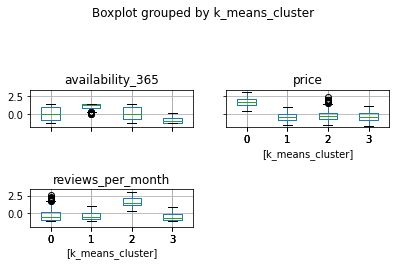

In [ ]:
# 시각화2: 모든 항목
import matplotlib.pyplot as plt
data.boxplot(by='k_means_cluster')
plt.tight_layout(pad=3, h_pad=3)
plt.show()

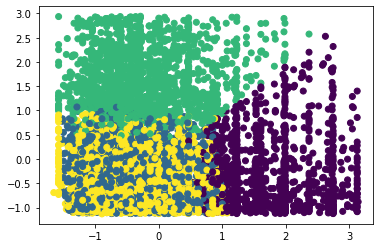

In [ ]:
# 군집결과 시각화: price-availability_365
plt.scatter(x=data['price'], y=data['reviews_per_month'], c=data['k_means_cluster'])

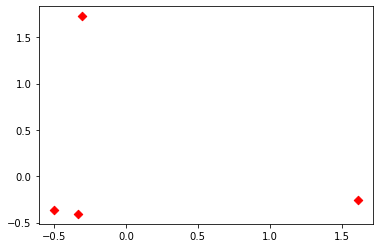

In [ ]:
# 군집별 중앙값 시각화: price-availability_365
plt.scatter(x=centers[:,0], y=centers[:,1], marker='D', c='r') 
plt.show()

In [ ]:
# 군집결과와 중앙값 함께 시각화: price-availability_365
plt.scatter(x=data['price'], y=data['reviews_per_month'], c=data['k_means_cluster']) 
plt.scatter(x=centers[:,0], y=centers[:,1], marker='D', c='r')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
k_score_samples = silhouette_samples(data, data['k_means_cluster'])

data['k_silhouette_coeff'] = k_score_samples
k_average_score = silhouette_score(data, data['k_means_cluster'])
print('데이터셋 Silhouette Analysis Score:{0:.3f}'.format(k_average_score))

데이터셋 Silhouette Analysis Score:0.484


In [ ]:
# 군집별 평균 silhouette_score 값
data.groupby('k_means_cluster')['k_silhouette_coeff'].mean()

k_means_cluster
0    0.371135
1    0.549684
2    0.329089
3    0.575579
Name: k_silhouette_coeff, dtype: float64

#### 